In [1]:
from t2_flujo import *
import folium
import matplotlib.pyplot as plt
import funciones
import parametros

# Parte 0

## pre pros

In [ ]:
N = []
for a in range(len(nodos_totales)):
    lista = nodos_totales.loc[a].to_list()
    nodo = funciones.Node(lista[0], lista[1], lista[2], lista[3], lista[4])
    N.append(nodo)

# DICCIONARIO DE ID EN EL MAPA Y EL ID QUE LE PUSE A LOS NODOS

ids = nodos_totales['id_nodo'].to_list()
nombres = nodos_totales['id'].to_list()

dict_ids_nombres = {}

for a in range(len(ids)):
    dict_ids_nombres[ids[a]] = nombres[a]

for a in range(1,parametros.P+1):
    nombres.append(f'PB{a}')

In [3]:
# Como se especifica que el transporte es desde los nodos de produccion a bodegas y demanda, y de los nodos
# de bodega                   a los nodos de demanda, elimino los arcos que no sirven para del grafo de todos los nodos conectados entre si.

# list(grafo_vial.edges(data=True))[par][origen/destino]
grafo_vial_nuevo = grafo_vial.copy()
lista_pares_nodos = list(grafo_vial_nuevo.edges())

for b in range(len(lista_pares_nodos)):
    a = lista_pares_nodos[b]
    
    O = nodos_totales[nodos_totales['id_nodo'] == a[0]]
    O_pos = O.index[0]

    D = nodos_totales[nodos_totales['id_nodo'] == a[1]]
    D_pos = D.index[0]

    if O['tipo'][O_pos] == D['tipo'][D_pos]:
        grafo_vial_nuevo.remove_edge(O['id_nodo'][O_pos],D['id_nodo'][D_pos])
    
    elif O['tipo'][O_pos] == 'demanda':
        grafo_vial_nuevo.remove_edge(O['id_nodo'][O_pos], D['id_nodo'][D_pos])

info_tipo_nodo = list(dict(grafo_vial_nuevo.nodes(data=True)).values())

In [4]:
# Las rutas minimas entre los nodos (todo el grafo se demora 1 min aprox)
r_min = funciones.rutas_min(grafo_vial_nuevo, parametros.G, len(list(grafo_vial_nuevo.edges())))
#graficar_rutas_min_n(r_min[0], G, 100)

In [5]:
# matriz de costos con las distancias entre los nodos en el mapa
matriz_costos = []
lista_arcos = list(grafo_vial_nuevo.edges(data=True))

for a in range(len(r_min[0])):
    matriz_costos.append([dict_ids_nombres[lista_arcos[a][0]],
                         dict_ids_nombres[lista_arcos[a][1]],
                         r_min[1][a],
                         r_min[0][a]])

In [6]:
matriz_costos_prod_dem = pd.DataFrame(columns=['origen', 'destino', 'distancia', 'ruta'])
matriz_costos_prod_bod = pd.DataFrame(columns=['origen', 'destino', 'distancia', 'ruta'])
matriz_costos_bod_dem = pd.DataFrame(columns=['origen', 'destino', 'distancia', 'ruta'])

for a in matriz_costos:
    if 'P' in a[0]:
        if 'D' in a[1]:
            matriz_costos_prod_dem = matriz_costos_prod_dem._append({'origen':a[0], 'destino':a[1], 'distancia':a[2], 'ruta':a[3]}, ignore_index=True)
        elif 'B' in a[1]:
            matriz_costos_prod_bod = matriz_costos_prod_bod._append({'origen':a[0], 'destino':a[1], 'distancia':a[2], 'ruta':a[3]}, ignore_index=True)
    if 'B' in a[0]:
        matriz_costos_bod_dem = matriz_costos_bod_dem._append({'origen':a[0], 'destino':a[1], 'distancia':a[2], 'ruta':a[3]}, ignore_index=True)

In [7]:
I = parametros.P
J = parametros.B + 1

# PARÁMETROS COMUNES ENTRE LA MATRIZ DE VIAJES Y COSTOS
columnas = list(nodos_bodegas.index)
filas = []
for a in range(1,I):
    columnas.append(a)
    filas.append(np.float64(0))
filas.append(np.float64(0))

dict_matriz = dict()
for b in range(0,J-1):
    dict_matriz[columnas[b]] = filas

prod_bodega = pd.DataFrame(data = dict_matriz)


prod_bodega['id'] = list(nodos_produccion.index)

prod_bodega = prod_bodega.set_index('id')

for i in range(len(matriz_costos_prod_bod)):
    fila = matriz_costos_prod_bod.loc[i]['origen']
    columna = matriz_costos_prod_bod.loc[i]['destino']
    guardar = matriz_costos_prod_bod.loc[i]['distancia']
    prod_bodega.loc[fila][columna] = guardar

In [8]:
I = parametros.P
J = parametros.D + 1

# PARÁMETROS COMUNES ENTRE LA MATRIZ DE VIAJES Y COSTOS
columnas = list(nodos_demanda.index)
filas = []
for a in range(1,I):
    columnas.append(a)
    filas.append(np.float64(0))
filas.append(np.float64(0))

dict_matriz = dict()
for b in range(0,J-1):
    dict_matriz[columnas[b]] = filas

prod_demanda = pd.DataFrame(data = dict_matriz)


prod_demanda['id'] = list(nodos_produccion.index)

prod_demanda = prod_demanda.set_index('id')

for i in range(len(matriz_costos_prod_dem)):
    fila = matriz_costos_prod_dem.loc[i]['origen']
    columna = matriz_costos_prod_dem.loc[i]['destino']
    guardar = matriz_costos_prod_dem.loc[i]['distancia']
    prod_demanda.loc[fila][columna] = guardar


In [9]:
I = parametros.B
J = parametros.D + 1

# PARÁMETROS COMUNES ENTRE LA MATRIZ DE VIAJES Y COSTOS
columnas = list(nodos_demanda.index)
filas = []
for a in range(1,I):
    columnas.append(a)
    filas.append(np.float64(0))
filas.append(np.float64(0))

dict_matriz = dict()
for b in range(0,J-1):
    dict_matriz[columnas[b]] = filas

bod_demanda = pd.DataFrame(data = dict_matriz)


bod_demanda['id'] = list(nodos_bodegas.index)

bod_demanda = bod_demanda.set_index('id')

for i in range(len(matriz_costos_bod_dem)):
    fila = matriz_costos_bod_dem.loc[i]['origen']
    columna = matriz_costos_bod_dem.loc[i]['destino']
    guardar = matriz_costos_bod_dem.loc[i]['distancia']
    bod_demanda.loc[fila][columna] = guardar

In [10]:
prod_demanda_distancias = prod_demanda
prod_demanda = round((prod_demanda / 1000) * 12)

prod_bodega_distancias = prod_bodega
prod_bodega = round((prod_bodega / 1000) * 12)

bod_demanda_distancias = bod_demanda
bod_demanda = round((bod_demanda / 1000) * 12)

# Parte I

## armo grafo

In [11]:
G1 = nx.DiGraph()

### Nodos

In [12]:
#se agregan los nodos correspondientes a las tiendas

entra = 0
sale = 0

for d in range(1, parametros.D+1):
  for t in range(1, parametros.T+1):
    nombre_nodo = 'D' + str(d) + ', t' + str(t)
    demanda = (demanda_max.loc[f'D{d}'][f'{t}'] - demanda_min.loc[f'D{d}'][f'{t}'])
    sale += demanda
    G1.add_node(nombre_nodo, demand = demanda)

In [13]:
#se agregan los nodos correspondientes a las fábricas

for p in range(1, parametros.P+1):
  for t in range(1, parametros.T):
    nombre_nodo = 'P' + str(p) + ', t' + str(t)
    oferta = (oferta_max_proveedores.loc[f'P{p}'][f'{t}'] - oferta_min_proveedores.loc[f'P{p}'][f'{t}'])
    entra += oferta
    G1.add_node(nombre_nodo, demand = -oferta)

In [14]:
inv_inicial_fabricas = inventario_inicial.to_dict()['1']
inv_inicial_bodegas = inventario_inicial_adicional.to_dict()['1']

In [15]:
#se agregan los nodos correspondientes a las bodegas de las fábricas

inv_0_fabricas = 0

for i in range(1, parametros.P + 1):
  for j in range(1, parametros.T + 1):
    nombre_nodo = 'P_bodega' + str(i) + ', t' + str(j)
    if j == 1:
      oferta = inv_inicial_fabricas[f'P{i}']
      inv_0_fabricas += oferta
      G1.add_node(nombre_nodo, demand = -oferta)
    else:
      G1.add_node(nombre_nodo)

In [16]:
#se agregan los nodos de bodegas adicionales
inv_0_bodegas = 0

for i in range(1, parametros.B+1):
  for j in range(1, parametros.T+1):
    nombre_nodo = 'B' + str(i) + ', t' + str(j)
    if j == 1:
      oferta = inv_inicial_bodegas[f'B{i}']
      inv_0_bodegas += oferta
      G1.add_node(nombre_nodo, demand = -oferta)
    else:
      G1.add_node(nombre_nodo)

In [17]:
#se agregan nodos auxiliares para todas las bodegas, tanto de fábricas como adicionales

for p in range(1, parametros.P + 1):
  for j in range(1, parametros.T +1):
    nombre_nodo = 'P_aux' + str(i) + ', t' + str(j)
    G1.add_node(nombre_nodo)

for i in range(1, parametros.B + 1):
  for j in range(1, parametros.T+1):
    nombre_nodo = 'B_aux' + str(i) + ', t' + str(j)
    G1.add_node(nombre_nodo)

In [18]:
suma=0
for a in list(G1.nodes(data=True)):
    if len(a[1])>0:
        suma += a[1]['demand']
print(suma)

-24096


In [19]:
G1.add_node('Sumidero', demand = -suma)

In [20]:
suma=0
for a in list(G1.nodes(data=True)):
    if len(a[1])>0:
        suma += a[1]['demand']
print(suma)

0


### Arcos

In [21]:
#se añaden los arcos desde cada fábrica a su nodo auxiliar en todos los periodos

for t in range(1, parametros.T):
  for i in range(1, parametros.P + 1):
      nombrefab = 'P' + str(i) + ', t' + str(t)
      nombreaux = 'P_aux' + str(i) + ', t' + str(t)
      costo_prod = costo_produccion.loc[f'P{i}'][f'{t}']
      G1.add_edge(nombrefab, nombreaux, weight = costo_prod)


In [22]:
#se agregan los arcos desde cada bodega de fábrica hasta cada tienda en todos los periodos

for t in range(1, parametros.T + 1):
  for b in range(1, parametros.P + 1):
    for s in range(1, parametros.D +1):
      costo_trans = prod_demanda.loc[f'P{b}'][f'D{s}']
      nombrebod = 'P_bodega' + str(b) + ', t' + str(t)
      nombretienda = 'D' + str(s) + ', t' + str(t)
      G1.add_edge(nombrebod, nombretienda, weight = costo_trans)

In [23]:
#agregamos el arco que une cada bodega de fábrica con el nodo auxiliar de esa fábrica del mismo periodo

for t in range(1, parametros.T+1):
  for b in range(1, parametros.P+1):
    nombrebod = 'P_bodega' + str(b) + ', t' + str(t)
    nombreaux = 'P_aux' + str(b) + ', t' + str(t)
    G1.add_edge(nombrebod, nombreaux, weight = 0)

In [24]:
#agregamos los arcos que unen el nodo auxiliar de la bodega de una fábrica con el nodo de la misma bodega pero
#en el periodo siguiente

for t in range(1, parametros.T):
  for b in range(1, parametros.P + 1):
    nombreaux = 'P_aux' + str(b) + ', t' + str(t)
    nombrebod = 'P_bodega' + str(b) + ', t' + str(t + 1)
    c_almacenaje = costo_almacenaje.loc[f'P{b}'][f'{t}']
    capacidad_max = capacidad_almacenaje.loc[f'P{b}'][f'{t}']
    G1.add_edge(nombreaux, nombrebod, weight = c_almacenaje, capacity = capacidad_max)

In [25]:
#agregamos arcos desde bodegas de fabricas hasta auxiliares de bodegas adicionales del mismo periodo

for t in range(1, parametros.T+1):
  for b in range(1, parametros.P +1):
    for a in range(1, parametros.B + 1):
      nombrebod = 'P_bodega' + str(b) + ', t' + str(t)
      nombreauxad = 'B_aux' + str(a) + ', t' + str(t)
      costo_trans = prod_bodega.loc[f'P{b}'][f'B{a}']
      G1.add_edge(nombrebod, nombreauxad, weight = costo_trans)

In [26]:
#agregamos arcos  desde nodos auxiliares de bodegas adicionales hasta la misma bodega en el siguiente periodo, para
#todos los periodos y todas las bodegas

for t in range(1, parametros.T):
  for a in range(1, parametros.B + 1):
    nombreauxad = 'B_aux' + str(a) + ', t' + str(t)
    nombrebodad = 'B' + str(a) + ', t' + str(t + 1)
    c_almacenaje = costo_almacenaje_adicional.loc[f'B{b}'][f'{t}']
    capacidad_max = capacidad_almacenaje_adicional.loc[f'B{b}'][f'{t}']
    G1.add_edge(nombreauxad, nombrebodad, weight = c_almacenaje, capacity = capacidad_max)

In [27]:
#agregamos el arco que une cada bodega adicional con el nodo auxiliar de esa bodega adicional del mismo periodo

for t in range(1, parametros.T+1):
  for a in range(1, parametros.B +1 ):
    nombrebodad = 'B' + str(a) + ', t' + str(t)
    nombreauxad = 'B_aux' + str(a) + ', t' + str(t)
    G1.add_edge(nombrebodad, nombreauxad, weight = 0)

In [28]:
#agregamos arcos que unen las bodegas adicionales con las tiendas para todos los periodos

for t in range(1, parametros.T +1):
  for s in range(1, parametros.D +1):
    for a in range(1, parametros.B +1):
      nombrebodad = 'B' + str(a) + ', t' + str(t)
      nombretienda = 'D' + str(s) + ', t' + str(t)
      costo_trans = bod_demanda.loc[f'B{a}'][f'D{s}']
      G1.add_edge(nombrebodad, nombretienda, weight = costo_trans)

In [29]:
#agregamos arcos desde fábricas hasta el sumidero para absorber el exceso de oferta

for t in range(1, parametros.T):
  for f in range(1, parametros.P + 1):
    nombrefab = 'P' + str(f) + ', t' + str(t)
    G1.add_edge(nombrefab, 'Sumidero', weight = 1000000000000)

In [30]:
'''#agregamos arcos desde bodegas auxiliares adicionales hasta el sumidero para absorber el exceso de oferta

for t in range(1, parametros.T + 1):
  for f in range(1, parametros.B + 1):
    nombrefab = 'B_aux' + str(f) + ', t' + str(t)
    G1.add_edge(nombrefab, 'Sumidero', weight = 10000000000000000)'''

"#agregamos arcos desde bodegas auxiliares adicionales hasta el sumidero para absorber el exceso de oferta\n\nfor t in range(1, parametros.T + 1):\n  for f in range(1, parametros.B + 1):\n    nombrefab = 'B_aux' + str(f) + ', t' + str(t)\n    G1.add_edge(nombrefab, 'Sumidero', weight = 10000000000000000)"

In [31]:
'''#agregamos arcos desde fabricas auxiliares adicionales hasta el sumidero para absorber el exceso de oferta

for t in range(1, parametros.T + 1):
  for f in range(1, parametros.P + 1):
    nombrefab = 'P_aux' + str(f) + ', t' + str(t)
    G1.add_edge(nombrefab, 'Sumidero', weight = 10000000000)'''

"#agregamos arcos desde fabricas auxiliares adicionales hasta el sumidero para absorber el exceso de oferta\n\nfor t in range(1, parametros.T + 1):\n  for f in range(1, parametros.P + 1):\n    nombrefab = 'P_aux' + str(f) + ', t' + str(t)\n    G1.add_edge(nombrefab, 'Sumidero', weight = 10000000000)"

In [32]:
'''#agregamos arcos desde fabricas auxiliares adicionales hasta el sumidero para absorber el exceso de oferta

for t in range(1, parametros.T + 1):
  for f in range(1, parametros.P + 1):
    nombrefab = 'P_bodega' + str(f) + ', t' + str(t)
    G1.add_edge(nombrefab, 'Sumidero', weight = 10000000000)'''

"#agregamos arcos desde fabricas auxiliares adicionales hasta el sumidero para absorber el exceso de oferta\n\nfor t in range(1, parametros.T + 1):\n  for f in range(1, parametros.P + 1):\n    nombrefab = 'P_bodega' + str(f) + ', t' + str(t)\n    G1.add_edge(nombrefab, 'Sumidero', weight = 10000000000)"

In [33]:
#agregamos arcos desde el sumidero hasta las tiendas en caso de que no se cumpla la demanda

for t in range(1, parametros.T+1):
  for s in range(1, parametros.D+1):
    costo_dda_no = 1000
    nombretienda = 'D' + str(s) + ', t' + str(t)
    G1.add_edge('Sumidero', nombretienda, weight = costo_dda_no)

### sol

In [34]:
sol = nx.min_cost_flow(G1, demand='demand', capacity='capacity', weight='weight')

# Parte II

In [35]:
# Lista con todos los nodos (nombre) y los periodos de tiempo en formato 't...'
bodegas = list(nodos_bodegas.index)
fabricas = list(nodos_produccion.index)
tiendas = list(nodos_demanda.index)

dias = []
for t in range(1, parametros.T+1):
  dias.append('t' + str(t))

fabricas_bodegas = []
fabricas_aux = []
for i in range(1, parametros.P + 1):
  fabricas_bodegas.append('P_bodega' + str(i))
  fabricas_aux.append('P_aux' + str(i))

bodegas_aux = []
for i in range(1, parametros.B + 1):
  fabricas_bodegas.append('B_aux' + str(i))

### Funciones

#### funcion 1

Construcción de una función que reciba como argumentos un periodo de tiempo, y que 
entregue un gráfico que muestre las plantas, bodegas y minoristas, y que ilustre las rutas 
y cargas transportadas entre estos nodos. Si además esta gráfica muestra niveles de 
inventario inicial y final en cada nodo, el grupo recibirá una bonificación.

In [41]:
# zzz

#### funcion 2

Construir una función que reciba como argumentos una bodega, y que entregue la 
evolución de su nivel de inventario. Esta función también debe permitir hacer este 
análisis en forma agregada para el sistema (es decir, sumado para todas las bodegas)

In [40]:
# con un poco de trabajo se puede hacer a partir de la funcion 3

#### funcion 3

Construir  una  función  que  construya  un  reporte  de  operación  diaria,  que  indique 
claramente el plan operativo del día, en un formato que podría ser fácilmente entendido 
por el personal responsable de ejecutar las instrucciones.

In [36]:
def imprimir_programacion(num_dia: int):
    if num_dia > 8:
        print('Día fuera del periodo productivo.')

    elif num_dia == 8:
        dia_actual = dias[num_dia-1]
        día_siguiente = dia_actual

    else:
        dia_actual = dias[num_dia-1]
        dia_siguiente = dias[num_dia]

    sol_1 = {}

    # saco de sol los nodos que no envian flujo, pongo los nodos que si envian algo en una nuevo diccionario

    for nodo_origen in list(sol.keys()):
        if dia_actual in nodo_origen:
            if len(sol[nodo_origen]) != 0:
                sol_1[nodo_origen] = sol[nodo_origen]

    sol_2 = {}
    for nodo_origen in list(sol_1.keys()):
        sol_2[nodo_origen] = {}
        for nodo_destino in sol_1[nodo_origen]:
            if sol_1[nodo_origen][nodo_destino] != 0:
                sol_2[nodo_origen][nodo_destino] = sol_1[nodo_origen][nodo_destino]

    # imprimo el tipo de nodo de origen desde el que envio

    for nodo_origen in (list(sol_2.keys())):
        if 'P_aux' not in nodo_origen and 'P_bod' not in nodo_origen and 'P' in nodo_origen:
            for nodo_destino in (list(sol_2[nodo_origen].keys())):
                if 'P_aux' in nodo_destino:
                    que_nodo = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                    cantidad = sol_2[nodo_origen][nodo_destino]
                    print(f'Fábrica {que_nodo} produce {cantidad} dulces.')

        if 'P_bodega' in nodo_origen:        
            for nodo_destino in (list(sol_2[nodo_origen].keys())):
                que_nodo_origen = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                que_nodo_destino = funciones.extraer_numeros(nodo_destino.split(',')[0])[0]

                cantidad = sol_2[nodo_origen][nodo_destino]
                if 'D' in nodo_destino:
                    print(f'Fábrica {que_nodo_origen} envia {cantidad} dulces a la casa {que_nodo_destino}.')
                
                if 'B' in nodo_destino:
                    print(f'Fábrica {que_nodo_origen} envia {cantidad} dulces a la bodega {que_nodo_destino}.')
        
        if 'P_aux' in nodo_origen:
            for nodo_destino in (list(sol_2[nodo_origen].keys())):            
                if dia_siguiente in nodo_destino:
                    que_nodo_origen = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                    que_nodo_destino = funciones.extraer_numeros(nodo_destino.split(',')[0])[0]
                    cantidad = sol_2[nodo_origen][nodo_destino]
                    print(f'Fábrica {que_nodo_origen} guarda {cantidad} dulces para el dia siguiente.')
        
        if 'B' in nodo_origen and 'B_aux' not in nodo_origen:
            for nodo_destino in (list(sol_2[nodo_origen].keys())):
                if 'D' in nodo_destino:
                    que_nodo_origen = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                    que_nodo_destino = funciones.extraer_numeros(nodo_destino.split(',')[0])[0]

                    cantidad = sol_2[nodo_origen][nodo_destino]
                    print(f'Fábrica {que_nodo_origen} envia {cantidad} dulces a la casa {que_nodo_destino}.')
        
        if 'B_aux' in nodo_origen:
            for nodo_destino in (list(sol_2[nodo_origen].keys())):
                if dia_siguiente in nodo_destino:
                    que_nodo_origen = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                    que_nodo_destino = funciones.extraer_numeros(nodo_destino.split(',')[0])[0]

                    cantidad = sol_2[nodo_origen][nodo_destino]
                    print(f'Bodega {que_nodo_origen} guarda {cantidad} dulces para el día siguiente.')

### otros

In [38]:
# me dice la demanda q el sumidero esta supliendo
for a in sol['Sumidero'].keys():
    if sol['Sumidero'][a] !=0:
        print(a,sol['Sumidero'][a])

D2, t1 104
D3, t1 254
D4, t1 304
D6, t1 400
D7, t1 270
D10, t1 305
D11, t1 304
D13, t1 64
D14, t1 226
D15, t1 206
D17, t1 161
D20, t1 201
D23, t1 200
D24, t1 47


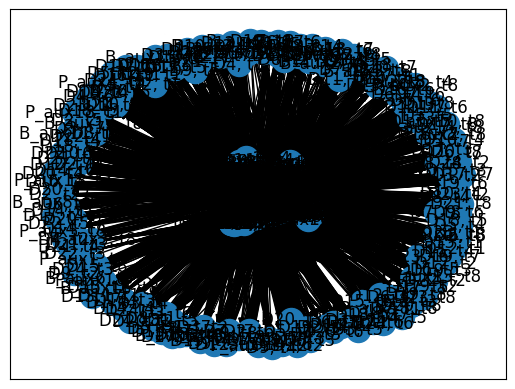

In [39]:
nx.draw_networkx(G1)